# Note
Use a GPU to run this notebook

# Install and import requirements

In [ ]:
%cd /content/drive/MyDrive/Github/Idoven
!pip install -qq -U -r requirements.txt
import numpy
import pandas
import ast
import copy 
import matplotlib.pyplot
import seaborn
import torch
import sklearn.preprocessing
import scipy.signal
import tqdm.notebook
import os
import utils

# Configure some parameters

In [2]:
path = 'physionet.org/files/ptb-xl/1.0.2/'
%matplotlib inline
seaborn.set(style='whitegrid', palette='Set2', font_scale=1.5)
matplotlib.pyplot.rcParams['figure.figsize'] = (10, 5)
matplotlib.pyplot.rcParams['figure.dpi'] = 100

RANDOM_SEED = 42
numpy.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Alert whether a 12-lead ECG-waveform is deviated from normal behavior
Let's use the lead I and a LSTM Autoencoder to reconstruct a 12-lead ECG as best as possible by capturing the most important features of a NORMAL 12-lead ECG. Because of the LSTM layers, the temporal dependencies have been kept in mind. 

## Data

In [3]:
data_ptbxl = pandas.read_csv(path + 'ptbxl_database.csv', index_col='ecg_id')
data_ptbxl.r_peaks = data_ptbxl.r_peaks.apply(lambda x: list(map(int, x.replace('[', '').replace(']', '').split())))
data_ptbxl.scp_codes = data_ptbxl.scp_codes.apply(lambda x: ast.literal_eval(x))
data_scp = pandas.read_csv(path + 'scp_statements.csv', index_col=0)
data_scp = data_scp[data_scp.diagnostic == 1]
data_ptbxl['diagnostic_superclass'] = data_ptbxl.scp_codes.apply(lambda x: utils.aggregate_superclasses(x, data_scp))
data_ptbxl = (data_ptbxl
              .loc[data_ptbxl.diagnostic_superclass.apply(len) != 0, :]
              .explode(['diagnostic_superclass'])
              )
data_ptbxl['binary_diagnostic_superclass'] = (data_ptbxl.diagnostic_superclass
                                              .apply(lambda x: 'ANOMALY' if x in ['CD', 'HYP', 'MI', 'STTC'] else 'NORMAL'))

Let's reconstruct each heartbeat instead of each ECG of 10 seconds length. I have cut each ECG at mid-distance R-peaks and made each heartbeat equal length using interpolation. I have used the function scipy.signal.find_peaks to detect the R-peaks. 

In [153]:
equal_length = 100
width = 10

def take_moving_average(x, w):
    return numpy.convolve(x, numpy.ones(w), 'valid') / w

def take_heartbeats(signals: numpy.array, moving_average: bool=True):
  heartbeats = []
  for signal in signals:
    r_peaks = list(scipy.signal.find_peaks(signal, distance=30, prominence=.75 * max(signal))[0])
    cuts = r_peaks[:-1] + numpy.diff(r_peaks) // 2
    for k, cut in enumerate(cuts):
      heartbeat = signal[cut: cuts[k+1]] if k not in [0, len(cuts) - 1] else signal[: cut] if k == 0 else signal[cut:] 
      heartbeat_equal_length = numpy.interp(range(equal_length), xp=range(len(heartbeat)), fp=heartbeat)
      if moving_average:
        heartbeat_equal_length = take_moving_average(heartbeat_equal_length, width)
      heartbeats.append(heartbeat_equal_length)
  heartbeats = numpy.array(heartbeats) 
  return heartbeats

In [154]:
# [:, :, 0] is because I am analyzing only the first lead (the lead I)

# training data
training_dataset = utils.load_ECGs(mode='training', superclass='NORMAL', data=data_ptbxl, n=5000)[:, :, 0]
training_dataset = take_heartbeats(training_dataset)

# validation data
validation_dataset = utils.load_ECGs(mode='validation', superclass='NORMAL', data=data_ptbxl, n=2000)[:, :, 0]
validation_dataset = take_heartbeats(validation_dataset)

# test data
test_normal_dataset = utils.load_ECGs(mode='test', superclass='NORMAL', data=data_ptbxl, n=1000)[:, :, 0]
test_normal_dataset = take_heartbeats(test_normal_dataset)

test_anomaly_dataset = utils.load_ECGs(mode='test', superclass='ANOMALY', data=data_ptbxl, n=1000)[:, :, 0]
test_anomaly_dataset = take_heartbeats(test_anomaly_dataset)

Before normalizing, understand the data because attributes can already have a meaningful and comparable scale. 


In [155]:
min_max_scaler = sklearn.preprocessing.MinMaxScaler()

# training data
training_dataset_scaled = min_max_scaler.fit_transform(training_dataset)

# validation data
validation_dataset_scaled = min_max_scaler.transform(validation_dataset)

# test data
test_normal_dataset_scaled = min_max_scaler.transform(test_normal_dataset)
test_anomaly_dataset_scaled = min_max_scaler.transform(test_anomaly_dataset)

Let's transform the data as a dataloader of pytorch tensors to optimize the training.

In [160]:
def transform_data_to_model(data: numpy.array, batch_size: int):
  data = torch.from_numpy(data)
  
  if device == "cuda":
    data = data.type(torch.cuda.FloatTensor)
  else:
    data = data.type(torch.FloatTensor)

  n_sample, n_length = data.shape
  data = torch.utils.data.DataLoader(data, batch_size=batch_size)
  return data, n_length

In [161]:
# training data
training, n_length = transform_data_to_model(data=training_dataset_scaled, batch_size=128) 
print(training.dataset.shape)

# validation data
validation, _ = transform_data_to_model(data=validation_dataset_scaled, batch_size=128) 
print(validation.dataset.shape)

# test data
test_normal, _ = transform_data_to_model(data=test_normal_dataset_scaled, batch_size=1) 
print(test_normal.dataset.shape)
test_anomaly, _ = transform_data_to_model(data=test_anomaly_dataset_scaled, batch_size=1)
print(test_anomaly.dataset.shape)

torch.Size([52140, 91])
torch.Size([9928, 91])
torch.Size([9865, 91])
torch.Size([10943, 91])


## Model

### Disclaimer
Don't use it. It is just a proof of concept. I should use a hyperparameter tuning library, like Optuna, to optimize the model architecture.

In [162]:
# first architecture option

class Encoder_LSTM_layers_1(torch.nn.Module):

  def __init__(self, n_length: int, hidden_size: int):
    super(Encoder_LSTM_layers_1, self).__init__()

    self.n_length = n_length
    self.hidden_size = hidden_size

    self.lstm = torch.nn.LSTM(
        input_size=1, # 1 is because the number of leads that I am analyzing
        hidden_size=self.hidden_size,
        num_layers=1,
        batch_first=True
        )
    
  def forward(self, x):
    batch_size = x.shape[0]
    x = x.reshape((batch_size, self.n_length, 1)) # 1 is because the number of leads that I am analyzing
    _, (hidden, _) = self.lstm(x)
    hidden = hidden.reshape((batch_size, self.hidden_size))
    return hidden

class Decoder_LSTM_layers_1(torch.nn.Module):

  def __init__(self, n_length: int, input_size: int):
    super(Decoder_LSTM_layers_1, self).__init__()

    self.n_length = n_length
    self.input_size = input_size

    self.lstm = torch.nn.LSTM(
        input_size=self.input_size,
        hidden_size=self.input_size,
        num_layers=1,
        batch_first=True
        )

    self.linear = torch.nn.Linear(self.input_size, 1) # 1 is because the number of leads that I am analyzing

  def forward(self, x):
    batch_size = x.shape[0]
    x = x.repeat(self.n_length, 1)
    x = x.reshape((batch_size, self.n_length, self.input_size))
    x, (_, _) = self.lstm(x)
    x = x.reshape((batch_size, self.n_length, self.input_size))
    x = self.linear(x)
    x = x.reshape((batch_size, self.n_length))
    return x

In [163]:
# second architecture option

class Encoder_LSTM_layers_2(torch.nn.Module):

  def __init__(self, n_length: int, hidden_size: int):
    super(Encoder_LSTM_layers_2, self).__init__()

    self.n_length = n_length
    self.hidden_size = hidden_size

    self.lstm1 = torch.nn.LSTM(
        input_size=1, # 1 is because the number of leads that I am analyzing
        hidden_size=2 * self.hidden_size,
        num_layers=1,
        batch_first=True
        )

    self.lstm2 = torch.nn.LSTM(
        input_size=2 * self.hidden_size,
        hidden_size=self.hidden_size,
        num_layers=1,
        batch_first=True
        )
    
  def forward(self, x):
    batch_size = x.shape[0]
    x = x.reshape((batch_size, self.n_length, 1)) # 1 is because the number of leads that I am analyzing
    x, (_, _) = self.lstm1(x)
    _, (hidden, _) = self.lstm2(x)
    hidden = hidden.reshape((batch_size, self.hidden_size))
    return hidden

class Decoder_LSTM_layers_2(torch.nn.Module):

  def __init__(self, n_length: int, input_size: int):
    super(Decoder_LSTM_layers_2, self).__init__()

    self.n_length = n_length
    self.input_size = input_size

    self.lstm1 = torch.nn.LSTM(
        input_size=self.input_size,
        hidden_size=self.input_size,
        num_layers=1,
        batch_first=True
        )

    self.lstm2 = torch.nn.LSTM(
        input_size=self.input_size,
        hidden_size=2 * self.input_size,
        num_layers=1,
        batch_first=True
        )

    self.linear = torch.nn.Linear(2 * self.input_size, 1) # 1 is because the number of leads that I am analyzing

  def forward(self, x):
    batch_size = x.shape[0]
    x = x.repeat(self.n_length, 1)
    x = x.reshape((batch_size, self.n_length, self.input_size))
    x, (_, _) = self.lstm1(x)
    x = x.reshape((batch_size, self.n_length, self.input_size))
    x, (_, _) = self.lstm2(x)
    x = x.reshape((batch_size, self.n_length, 2 * self.input_size))
    x = self.linear(x)
    x = x.reshape((batch_size, self.n_length))
    return x

In [164]:
# third architecture option

class Encoder_LSTM_layers_3(torch.nn.Module):

  def __init__(self, n_length: int, hidden_size: int):
    super(Encoder_LSTM_layers_3, self).__init__()

    self.n_length = n_length
    self.hidden_size = hidden_size

    self.lstm1 = torch.nn.LSTM(
        input_size=1, # 1 is because the number of leads that I am analyzing
        hidden_size=(2 ** 2) * self.hidden_size,
        num_layers=1,
        batch_first=True
        )
    
    self.lstm2 = torch.nn.LSTM(
        input_size=(2 ** 2) * self.hidden_size,
        hidden_size=2 * self.hidden_size,
        num_layers=1,
        batch_first=True
        )
    
    self.lstm3 = torch.nn.LSTM(
        input_size=2 * self.hidden_size,
        hidden_size=self.hidden_size,
        num_layers=1,
        batch_first=True
        )
    
  def forward(self, x):
    batch_size = x.shape[0]
    x = x.reshape((batch_size, self.n_length, 1)) # 1 is because the number of leads that I am analyzing
    x, (_, _) = self.lstm1(x)
    x, (_, _) = self.lstm2(x)
    _, (hidden, _) = self.lstm3(x)
    hidden = hidden.reshape((batch_size, self.hidden_size))
    return hidden

class Decoder_LSTM_layers_3(torch.nn.Module):

  def __init__(self, n_length: int, input_size: int):
    super(Decoder_LSTM_layers_3, self).__init__()

    self.n_length = n_length
    self.input_size = input_size

    self.lstm1 = torch.nn.LSTM(
        input_size=self.input_size,
        hidden_size=self.input_size,
        num_layers=1,
        batch_first=True
        )

    self.lstm2 = torch.nn.LSTM(
        input_size=self.input_size,
        hidden_size=2 * self.input_size,
        num_layers=1,
        batch_first=True
        )
    
    self.lstm3 = torch.nn.LSTM(
        input_size=2 * self.input_size, 
        hidden_size=(2 ** 2) * self.input_size, 
        num_layers=1, 
        batch_first=True
        )

    self.linear = torch.nn.Linear((2 ** 2) * self.input_size, 1) # 1 is because the number of leads that I am analyzing

  def forward(self, x):
    batch_size = x.shape[0]
    x = x.repeat(self.n_length, 1)
    x = x.reshape((batch_size, self.n_length, self.input_size))
    x, (_, _) = self.lstm1(x)
    x = x.reshape((batch_size, self.n_length, self.input_size))
    x, (_, _) = self.lstm2(x)
    x = x.reshape((batch_size, self.n_length, 2 * self.input_size))
    x, (_, _) = self.lstm3(x)
    x = x.reshape((batch_size, self.n_length, (2 ** 2) * self.input_size))
    x = self.linear(x)
    x = x.reshape((batch_size, self.n_length))
    return x

In [165]:
class LSTMAutoencoder(torch.nn.Module):

  def __init__(self, n_length: int, hidden_size: int):
    super(LSTMAutoencoder, self).__init__()

    # first architecture option
    # self.encoder = Encoder_LSTM_layers_1(n_length, hidden_size).to(device)
    # self.decoder = Decoder_LSTM_layers_1(n_length, hidden_size).to(device)

    # second architecture option
    # self.encoder = Encoder_LSTM_layers_2(n_length, hidden_size).to(device)
    # self.decoder = Decoder_LSTM_layers_2(n_length, hidden_size).to(device)

    # third architecture option
    self.encoder = Encoder_LSTM_layers_3(n_length, hidden_size).to(device)
    self.decoder = Decoder_LSTM_layers_3(n_length, hidden_size).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

  def fit(self, training_dataset: torch.tensor, validation_dataset: torch.tensor, n_epochs: int):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
    criterion = torch.nn.L1Loss(reduction='mean').to(device)
    history = dict(training=[], validation=[])
    best_loss = numpy.Inf

    if os.path.isfile('./checkpoint.pt'):
      checkpoint = torch.load('./checkpoint.pt')
      start_epoch = checkpoint['epoch']
      self.load_state_dict(checkpoint['state_dict'])
      optimizer.load_state_dict(checkpoint['optimizer'])
    else:
      checkpoint = {'epoch': 0, 'state_dict': self.state_dict()}
      start_epoch = checkpoint['epoch']
    
    epochs = tqdm.notebook.tqdm(range(start_epoch, start_epoch + n_epochs))
    for epoch in epochs:
      
      self.train()
      training_losses = []

      for data in training_dataset:
      
        optimizer.zero_grad()
        data = data.to(device)
        pred = self(data)
        loss = criterion(pred, data)
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())

      self.eval()
      validation_losses = []
      with torch.no_grad():

        for data in validation_dataset:

          data = data.to(device)
          pred = self(data)
          loss = criterion(pred, data)
          validation_losses.append(loss.item())

      training_loss = numpy.mean(training_losses)
      validation_loss = numpy.mean(validation_losses)
      history['training'].append(training_loss)
      history['validation'].append(validation_loss)

      epochs.set_description(f'Epoch [{epoch + 1}/{start_epoch + n_epochs}], training loss [{training_loss:.6f}], validation loss [{validation_loss:.6f}]')

      if validation_loss < best_loss:
        checkpoint = {'epoch': epoch + 1, 'state_dict': self.state_dict(), 'optimizer': optimizer.state_dict()}
        torch.save(checkpoint, './checkpoint.pt')
        best_loss = validation_loss

    self.load_state_dict(checkpoint['state_dict'])
    return self.eval(), history

### Training

In [178]:
model = LSTMAutoencoder(n_length=n_length, hidden_size=32).to(device)
model, history = model.fit(training_dataset=training, validation_dataset=validation, n_epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

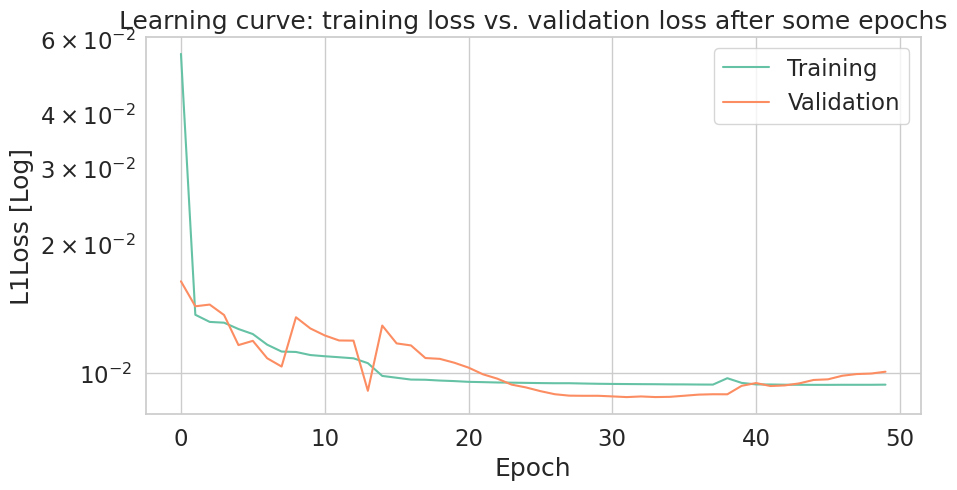

In [179]:
ax = matplotlib.pyplot.figure().gca()
ax.plot(history['training'])
ax.plot(history['validation'])
matplotlib.pyplot.ylabel('L1Loss [Log]')
matplotlib.pyplot.yscale("log")
matplotlib.pyplot.xlabel('Epoch')
matplotlib.pyplot.legend(['Training', 'Validation'])
matplotlib.pyplot.title('Learning curve: training loss vs. validation loss after some epochs')
matplotlib.pyplot.show();

### Evaluation: Choose the optimal reconstruction loss threshold

It is the one with the lowest rate of false positives and negatives. A 12-lead ECG will be classified as NORMAL if the reconstruction loss is below the threshold.

In [ ]:
"""
model = LSTMAutoencoder(n_length=n_length, hidden_size=64).to(device)
checkpoint = torch.load('./checkpoint.pt')
model.load_state_dict(checkpoint['state_dict'])
model
"""

In [168]:
def predict(model: torch.nn.Module, dataset: torch.tensor):
  predictions, losses = [], []
  criterion = torch.nn.L1Loss(reduction='mean').to(device)
  
  with torch.no_grad():
    model.eval()
    for data in dataset:
      data = data.to(device)
      pred = model(data)
      loss = criterion(pred, data)
      predictions.append(pred.cpu().numpy())
      losses.append(loss.item())
  
  return predictions, losses

In [ ]:
"""
training_predictions, training_losses = predict(model, training)
seaborn.histplot(training_losses, bins=50, kde=True);
validation_predictions, validation_losses = predict(model, validation)
seaborn.histplot(validation_losses, bins=50, kde=True);
"""

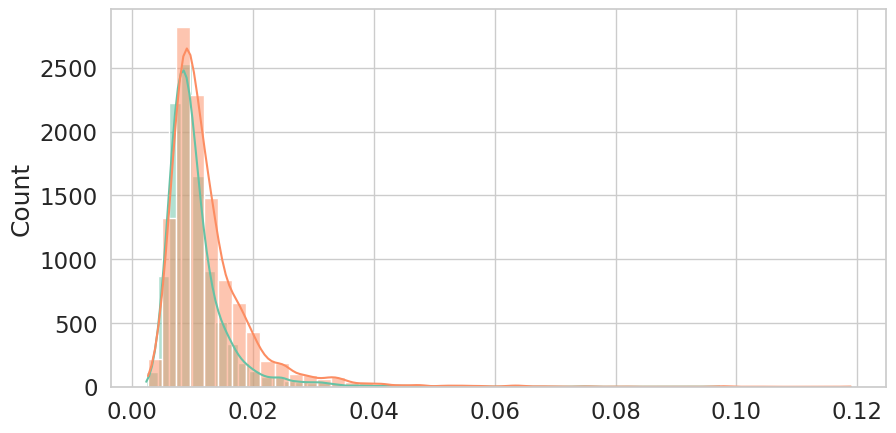

In [180]:
_, test_normal_losses = predict(model, test_normal)
_, test_anomaly_losses = predict(model, test_anomaly)
seaborn.histplot(test_normal_losses, bins=50, kde=True)
seaborn.histplot(test_anomaly_losses, bins=50, kde=True)

In [181]:
THRESHOLD = .01

correct = sum(l <= THRESHOLD for l in test_normal_losses)
n = len(test_normal_losses)
print(f'Sensitivity: {correct}/{n} ({round(100*correct/n, 2)}%)')

correct = sum(l > THRESHOLD for l in test_anomaly_losses)
n = len(test_anomaly_losses)
print(f'Specificity: {correct}/{n} ({round(100*correct/n, 2)}%)')

Sensitivity: 5824/9865 (59.04%)
Specificity: 6145/10943 (56.15%)


In [171]:
def plot_prediction(data, model, title, ax):
  predictions, losses = predict(model, [data.reshape((1, n_length, 1))])
  ax.plot(data, label='ECG')
  ax.plot(predictions[0][0], label='Reconstruction')
  ax.set_title(f'{title} (loss: {numpy.around(losses[0], 3)})')
  ax.legend()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1, 91, 1])) that is different to the input size (torch.Size([1, 91])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1, 91, 1])) that is different to the input size (torch.Size([1, 91])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1, 91, 1])) that is different to the input size (torch.Size([1, 91])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1

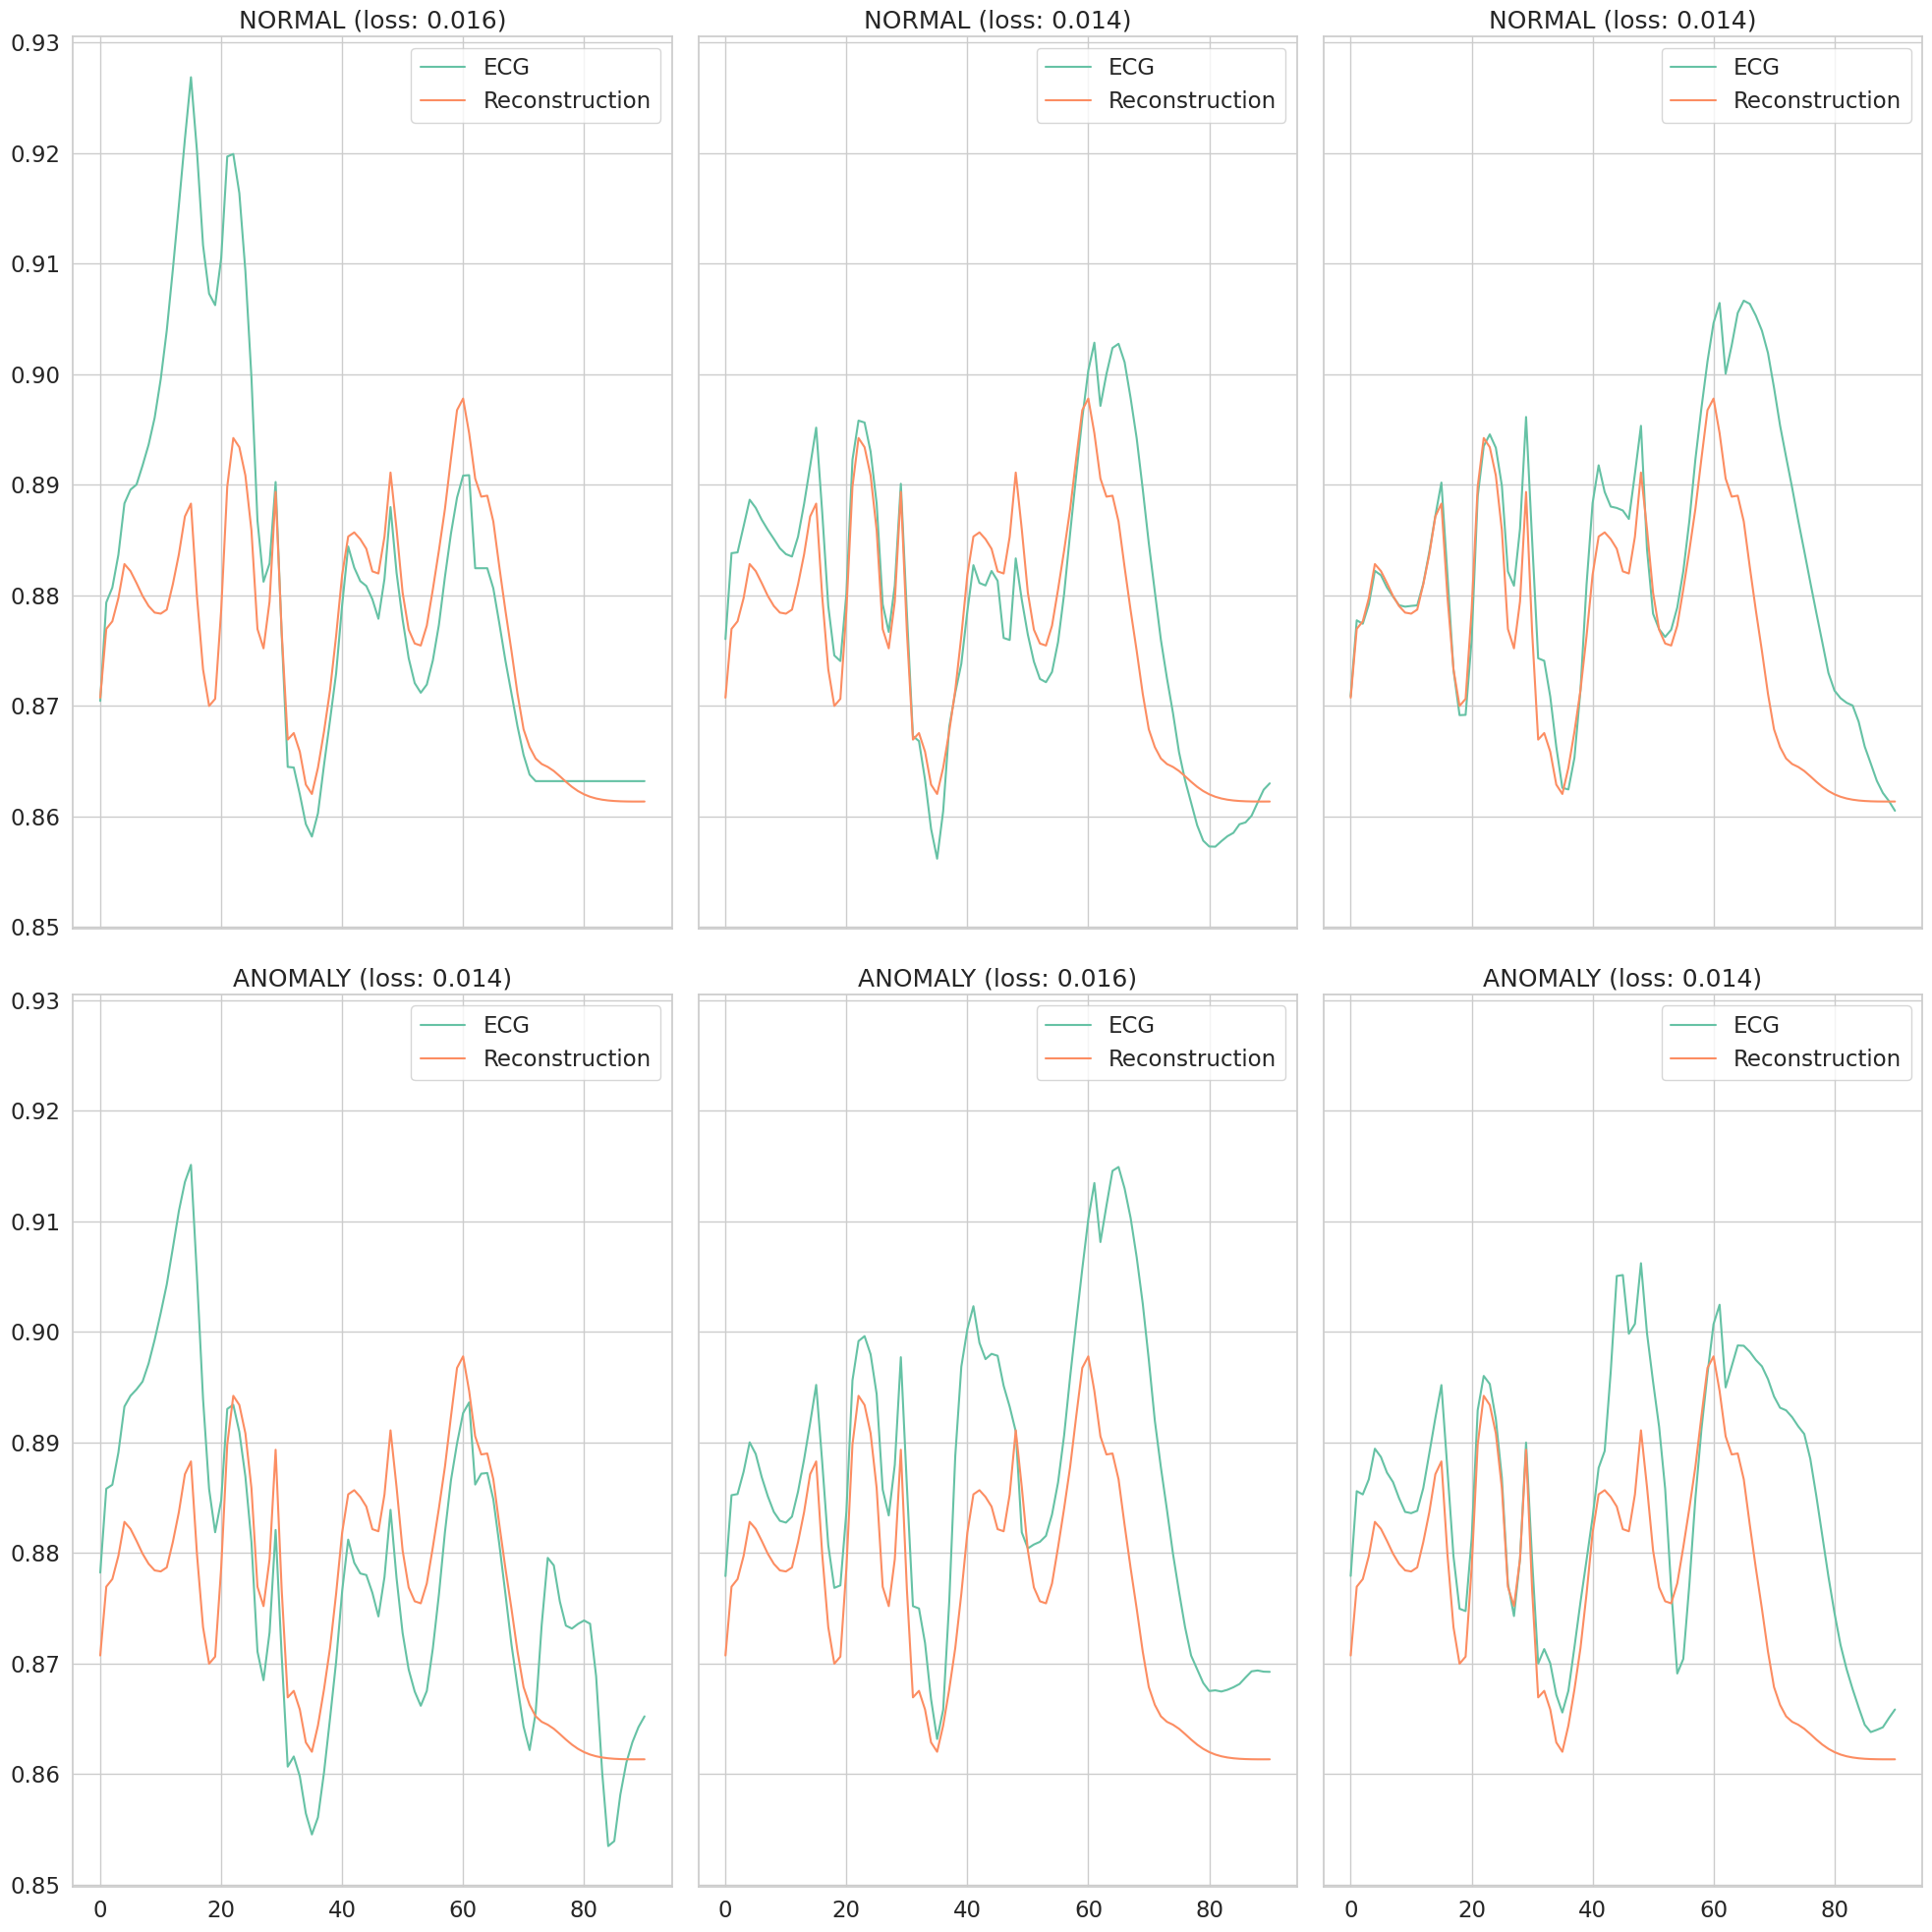

In [182]:
fig, axs = matplotlib.pyplot.subplots(
  nrows=2,
  ncols=3,
  sharey=True,
  sharex=True,
  figsize=(20, 20)
)

for i, data in enumerate(test_normal.dataset[:3]):
  plot_prediction(data, model, title='NORMAL', ax=axs[0, i])

for i, data in enumerate(test_anomaly.dataset[:3]):
  plot_prediction(data, model, title='ANOMALY', ax=axs[1, i])

fig.tight_layout();

### Conclusion
I have made some changes with respect to the previous notebook:

* I have taken all the heartbeats to reconstruct a normal heartbeat of 1 second length approx. instead of taken all the ECGs to reconstruct an entire normal ECG of 10 seconds length. The trained model is: 
** Lighter because the model needs fewer parameters (the size of each sample of the training data is 100 x 12 approx. instead of being 1000 x 12).
** More robust because the model has 10 times approx. more training, validation and test data.
** More synchronous because the model detects anomalies closer to real time by sequentially recording and evaluating every heartbeat of the ECG instead of recording and evaluating the entire ECG.

* I have normalized the heartbeats and made a dataloader of tensors with a batch size greater than 1 to improve the learning.
* I have taken the moving average for each heartbeat to remove the noise.
* I have made some minor changes to make the code clearer like inserting the training method into the autoencoder class called fit.

Note I could introduce more leads including the variable n_features into the autoencoder as I did with batch_size to detect whether the entire 12-lead ECG-waveform is deviated from normal behavior instead of just looking the lead I.